------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------



Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.


**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused.

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [ ]:
!python --version

Python 3.10.12


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [99]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
#from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

In [100]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json


--2023-11-08 10:47:39--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon.1’

sent_lexicon.1      100%[===================>] 647.05K  --.-KB/s    in 0.04s   

2023-11-08 10:47:39 (17.8 MB/s) - ‘sent_lexicon.1’ saved [662577/662577]

--2023-11-08 10:47:39--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercont

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [101]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

def print_sentence(s):
  print(" ".join(s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 10:
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1


print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))


Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.
5 NEG 35
In/I

In [102]:
pene = []

for i, r in enumerate(reviews):
    tokens = [token[0] for token in r["content"][0]]
    sentence = " ".join(tokens)
    hola = sentence.split(' ')
    pene.append(hola)

    if i == 1:
        break

# Now, reviews will contain a list of strings, each representing a sentence.
pene

[['Two',
  'teen',
  'couples',
  'go',
  'to',
  'a',
  'church',
  'party',
  ',',
  'drink',
  'and',
  'then',
  'drive',
  '.'],
 ['Damn', 'that', 'Y2K', 'bug', '.']]

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [103]:
# Initialize an empty dictionary to store word polarity information
lexicon_dict = {}

# Open the file named "sent_lexicon" for reading with UTF-8 encoding
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    # Iterate through each line in the file
    for line in f:
        # Split the line into a list of pairs
        pairs = line.split()

        # Extract the word from the line (it's found in the third position and separated by '=')
        word = pairs[2].split('=')[1]

        # Extract the polarity information (it's found in the last position and separated by '=')
        polarity = pairs[-1].split('=')[1]

        # Check the polarity value and convert it to a numeric value
        if polarity == "positive":
            polarity = 1
        elif polarity == "negative":
            polarity = -1
        else:
            polarity = 0  # If neither positive nor negative, assume polarity as 0 (neutral)

        # Add the word and its corresponding polarity to the lexicon_dict dictionary
        lexicon_dict[word] = polarity


In [104]:
# Initialize empty lists to store the token-based results, ground truth results, and an intermediate list 'pene'
token_results = []
ground_results = []

# Iterate through each review in the 'reviews' list
for review in reviews:
    # Check the sentiment label of the review and convert it to binary (1 for 'POS', 0 for other sentiments)
    if review['sentiment'] == 'POS':
        ground_results.append(1)
    else:
        ground_results.append(0)

    # Initialize the sum for the current review
    review_sum = 0

    # Iterate through each sentence in the 'content' of the review
    for sentence in review["content"]:
        # Extract tokens from the sentence
        sentence_tokens = [token for token, _ in sentence]

        # Look up token values in the 'lexicon_dict' and replace them with 0 if not found
        sentence_tokens_values = [lexicon_dict.get(token, 0) for token in sentence_tokens]

        # Accumulate the sum of token values for the current review
        review_sum += sum(sentence_tokens_values)

        # Append the cumulative 'review_sum' to the 'pene' list for this review

    # Check if the cumulative sum for the review is greater than 8
    if review_sum > 8:
        token_results.append(1)
    else:
        token_results.append(0)

# Calculate token-based accuracy by comparing 'token_results' with 'ground_results'
token_accuracy = 0
for x, y in zip(token_results, ground_results):
    if x == y:
        token_accuracy += 1

# Calculate the overall accuracy and store it in 'accuracy_1'
accuracy_1 = token_accuracy / len(reviews)

# Print the accuracy as a percentage with two decimal places
print("Accuracy: %0.2f" % accuracy_1)



Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [105]:
# Initialize an empty dictionary to store word polarity information
lexicon_dict = {}

# Open the file named "sent_lexicon" for reading with UTF-8 encoding
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    # Iterate through each line in the file
    for line in f:
        # Split the line into a list of pairs based on whitespace
        pairs = line.split()

        # Extract the word from the line (it's found in the third position and separated by '=')
        word = pairs[2].split('=')[1]

        # Extract the polarity information (it's found in the last position and separated by '=')
        pol = pairs[-1].split('=')[1]

        # Extract the subtype of the word (it's found in the first position and separated by '=')
        subtype = pairs[0].split('=')[1]

        # Initialize the polarity variable to 0 (neutral)
        polarity = 0

        # Check the polarity value and convert it to a numeric value
        if pol == "positive":
            polarity = 1
        elif pol == "negative":
            polarity = -1
        else:
            polarity = 0

        # If the subtype is 'strongsubj', double the polarity value
        if subtype == 'strongsubj':
            polarity *= 2

        # Add the word and its corresponding polarity to the lexicon_dict dictionary
        lexicon_dict[word] = polarity


In [106]:
# Initialize an empty list to store the token-based results for a different set (token_results_2)
# and a list to store the ground truth results
token_results_2 = []
ground_results = []

# Iterate through each review in the 'reviews' list
for review in reviews:
    # Check the sentiment label of the review and convert it to binary (1 for 'POS', 0 for other sentiments)
    if review['sentiment'] == 'POS':
        ground_results.append(1)
    else:
        ground_results.append(0)

    # Initialize the sum for the current review
    review_sum = 0

    # Iterate through each sentence in the 'content' of the review
    for sentence in review["content"]:
        # Extract tokens from the sentence
        sentence_tokens = [token for token, _ in sentence]

        # Look up token values in the 'lexicon_dict' and replace them with 0 if not found
        sentence_tokens_values = [lexicon_dict.get(token, 0) for token in sentence_tokens]

        # Accumulate the sum of token values for the current review
        review_sum += sum(sentence_tokens_values)

    # Check if the cumulative sum for the review is greater than 8
    if review_sum > 8:
        token_results_2.append(1)
    else:
        token_results_2.append(0)

# Calculate token-based accuracy by comparing 'token_results_2' with 'ground_results'
token_accuracy = 0
for x, y in zip(token_results_2, ground_results):
    if x == y:
        token_accuracy += 1

# Calculate the overall accuracy for this set and store it in 'accuracy_2'
accuracy_2 = token_accuracy / len(reviews)

# Print the accuracy as a percentage with two decimal places
print("Accuracy: %0.2f" % accuracy_2)


Accuracy: 0.68


#### (Q.1.3) Make a barplot of the two results (0.5pt)

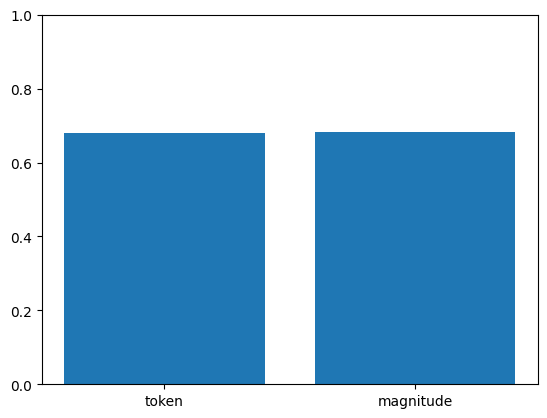

In [107]:
plt.bar(['token', 'magnitude'],[accuracy_1, accuracy_2])
plt.ylim([0, 1])
# Show Plot
plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

*Write your answer here.*

In [108]:
length = []
for review in reviews:
    content_length = len(review["content"])
    length.append(content_length)

average_len_review = np.average(length)

token_results_3 = []

for review in reviews:
    review_sum = 0  # Initialize the sum for the review
    review_len = len(review['content'])
    for sentence in review["content"]:
        sentence_tokens = [token for token, _ in sentence]
        sentence_tokens_values = [lexicon_dict.get(token, 0) for token in sentence_tokens]
        review_sum += sum(sentence_tokens_values)  # Accumulate the sum for the review

    avg_sentiment_word = review_sum / review_len

    # Calculate the threshold based on the average review length
    if avg_sentiment_word == 0:
        # Apply a smoothing factor (0.1) to avoid division by zero
        threshold = 8/(0.1 * average_len_review * review_len)
    else:
        threshold = 8/(avg_sentiment_word * average_len_review * review_len)

    if review_sum > threshold:
        token_results_3.append(1)
    else:
        token_results_3.append(0)


token_accuracy = 0
for x, y in zip(token_results_3, ground_results):
  if x == y:
    token_accuracy += 1

accuracy_3 = token_accuracy/len(reviews)

print("Accuracy: %0.2f", accuracy_3)

Accuracy: %0.2f 0.648


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

*Write your answer here.*

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)



In [109]:
def train(reviews, smoothing):
    # Initialize sets to store unique words in positive and negative reviews
    voc_pos = set()
    voc_neg = set()

    # Initialize counters for positive and negative reviews
    pos = 0
    neg = 0

    # Dictionaries to store word frequencies in positive and negative reviews
    positive_word_count = {}
    negative_word_count = {}

    # Iterate through the training reviews
    for review in reviews:
        # Check if the review sentiment is positive
        if review['sentiment'] == 'POS':
            pos += 1  # Increment the positive review count
            for sentence in review['content']:
                for word, _ in sentence:
                    # Add words to the positive vocabulary set and update their counts
                    if word not in voc_pos:
                        positive_word_count[word.lower()] = 1
                        voc_pos.add(word.lower())
                        #positive_word_count[word] = 1
                    else:
                        positive_word_count[word.lower()] += 1
        else:
            neg += 1  # Increment the negative review count
            for sentence in review['content']:
                for word, _ in sentence:
                    # Add words to the negative vocabulary set and update their counts
                    if word not in voc_neg:
                        voc_neg.add(word.lower())
                        negative_word_count[word.lower()] = 1
                    else:
                        negative_word_count[word.lower()] += 1

    # Calculate prior probabilities for positive and negative reviews
    prior_positive = pos / len(reviews)
    prior_negative = neg / len(reviews)

    # Create dictionaries to store probabilities for positive and negative words
    prob_pos = {}
    prob_neg = {}

    # Calculate probabilities for positive words using Laplace smoothing
    P = sum(positive_word_count.values())   # Total word count in positive reviews
    for word in voc_pos:
      if not smoothing:
        prob_pos[word.lower()] = (positive_word_count[word.lower()]) / (P)
      else:
        prob_pos[word.lower()] = (positive_word_count[word.lower()] + 1) / (P + len(voc_pos))


    # Calculate probabilities for negative words using Laplace smoothing
    N = sum(negative_word_count.values())  # Total word count in negative reviews
    for word in voc_neg:
      if not smoothing:
        prob_neg[word.lower()] = (negative_word_count[word.lower()]) / (N)
      else:
        prob_neg[word.lower()] = (negative_word_count[word.lower()] + 1) / (N + len(voc_neg))


    return prior_positive, prior_negative, voc_pos, voc_neg, prob_pos, prob_neg

def test(reviews, prior_positive, prior_negative ,voc_pos, voc_neg, prob_pos, prob_neg):
    predictions = []  # Store class predictions for each review

    for review in reviews:
        score_pos = np.log(prior_positive)
        score_neg = np.log(prior_negative)

        for sentence in review['content']:
            for token, _ in sentence:
                if token.lower() in voc_pos:
                    # Token found in training data, use its probability for the positive class
                    score_pos += np.log(prob_pos[token.lower()])
                if token.lower() in voc_neg:
                    # Token found in training data, use its probability for the negative class
                    score_neg += np.log(prob_neg[token.lower()])

        # Compare the accumulated scores to make a prediction
        if score_pos > score_neg:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions

def accuracy(reviews, predictions):
    ground_results = []
    for review in reviews:
        # Check the sentiment label of the review and convert it to binary (1 for 'POS', 0 for other sentiments)
        if review['sentiment'] == 'POS':
            ground_results.append(1)
        else:
            ground_results.append(0)
    if len(ground_results) == len(predictions):
        token_accuracy = 0
        for x, y in zip(predictions, ground_results):
            if x == y:
                token_accuracy += 1

        accuracy = token_accuracy/len(reviews)
    else:
        raise TypeError('Lists of different sizes for accuracy testing')

    print("Accuracy:", accuracy)

    return accuracy

In [110]:
train_reviews = reviews[:900] + reviews[1000:1900]
test_reviews = reviews[900:1000] + reviews[1900:2000]

prior_positive, prior_negative ,voc_pos, voc_neg, prob_pos, prob_neg = train(train_reviews, False)

predictions = test(test_reviews, prior_positive, prior_negative ,voc_pos, voc_neg, prob_pos, prob_neg)

accuracy(test_reviews, predictions)

Accuracy: 0.44


0.44

#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

No.

In [111]:
train_reviews = reviews[:89] + reviews[1000:1900]
test_reviews = reviews[900:909] + reviews[1900:2000]
# NB
prior_positive, prior_negative ,voc_pos, voc_neg, prob_pos, prob_neg = train(train_reviews, False)

predictions_NB = test(test_reviews, prior_positive, prior_negative ,voc_pos, voc_neg, prob_pos, prob_neg)

accuracy(test_reviews, predictions_NB)

Accuracy: 0.08256880733944955


0.08256880733944955

## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)} for a word
<!-- $w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$

#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [112]:
train_reviews = reviews[:900] + reviews[1000:1900]
test_reviews = reviews[900:1000] + reviews[1900:2000]

prior_positive, prior_negative ,voc_pos, voc_neg, prob_pos, prob_neg = train(train_reviews,True)

predictions = test(test_reviews, prior_positive, prior_negative ,voc_pos, voc_neg, prob_pos, prob_neg)

accuracy(test_reviews, predictions)

Accuracy: 0.41


0.41

## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [113]:
#round-robin splitting
def round_robin_split1(reviews, k, smoothing):
  acc = []
  for j in range(k):
    data_test = []  # Initialize data_test for this fold
    data_train = []  # Initialize data_train for this fold

    for i in range(k):
        if j == i:
            data_test = reviews[i::k]  # Get the test data
        else:
          #que?
            data_train += [d for idx, d in enumerate(reviews) if idx % k != i]  # Get the training data

    prior_positive, prior_negative, voc_pos, voc_neg, prob_pos, prob_neg = train(data_train, smoothing)

    predictions = test(data_test, prior_positive, prior_negative, voc_pos, voc_neg, prob_pos, prob_neg)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy(data_test, predictions)
    acc.append(fold_accuracy)

  return acc


def round_robin_split(reviews, k, smoothing):
    # split the reviews in k folds
    folds = []
    for i in range(k):
        folds.append(reviews[i::k])

    accuracies = []

    for i in range(k):
        train_reviews = []
        for j in range(k):
            if j != i:
                train_reviews += folds[j]
        test_reviews = folds[i]

        prior_positive, prior_negative ,voc_pos, voc_neg, prob_pos, prob_neg = train(train_reviews, smoothing)

        predictions = test(test_reviews, prior_positive, prior_negative ,voc_pos, voc_neg, prob_pos, prob_neg)

        accuracies.append(accuracy(test_reviews, predictions))

    return accuracies


accuracies = round_robin_split(reviews, 10, True)
print("Accuracies:", accuracies)
acc = round_robin_split1(reviews, 10, True)
print("Accuracies:", acc)



Accuracy: 0.44
Accuracy: 0.44
Accuracy: 0.44
Accuracy: 0.425
Accuracy: 0.465
Accuracy: 0.425
Accuracy: 0.455
Accuracy: 0.48
Accuracy: 0.43
Accuracy: 0.47
Accuracies: [0.44, 0.44, 0.44, 0.425, 0.465, 0.425, 0.455, 0.48, 0.43, 0.47]
Accuracy: 0.035
Accuracy: 0.035
Accuracy: 0.05
Accuracy: 0.05
Accuracy: 0.015
Accuracy: 0.025
Accuracy: 0.035
Accuracy: 0.03
Accuracy: 0.05
Accuracy: 0.08
Accuracies: [0.035, 0.035, 0.05, 0.05, 0.015, 0.025, 0.035, 0.03, 0.05, 0.08]


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [115]:
# YOUR CODE HERE
def variance(x):
    m = sum(x)/len(x)
    num = 0
    for i in x:
        num += (i - m)**2

    var = num/len(x)

    return var

In [116]:
variance(acc)

0.00029225000000000003

## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [117]:
def porter_stemmer(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens


#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


In [120]:
print_sentence_with_pos(reviews[0]["content"][0])

# apply the porter stemmer to the reviews, and store the results in a new list
stemmed_reviews = reviews.copy()
for review in stemmed_reviews:
    for sentence in review["content"]:
        for i, (token, pos_tag) in enumerate(sentence):
            new_token = porter_stemmer([token])[0]
            sentence[i] = (new_token, pos_tag)

# print the first sentence of the first review
print_sentence_with_pos(stemmed_reviews[0]["content"][0])


# print_sentence_with_pos(new_reviews[0]["content"][0])

# now we use round robin splitting with the porter stemmer
accuracies = round_robin_split(stemmed_reviews, 10, True)
print("Accuracies:", accuracies)
# accuracies = round_robin_split1(reviews, 10, True)
# print("Accuracies:", accuracies)

two/CD teen/JJ coupl/NNS go/VBP to/TO a/DT church/NN parti/NN ,/, drink/NN and/CC then/RB drive/NN ./.
two/CD teen/JJ coupl/NNS go/VBP to/TO a/DT church/NN parti/NN ,/, drink/NN and/CC then/RB drive/NN ./.
Accuracy: 0.52
Accuracy: 0.45
Accuracy: 0.47
Accuracy: 0.495
Accuracy: 0.385
Accuracy: 0.46
Accuracy: 0.495
Accuracy: 0.51
Accuracy: 0.495
Accuracy: 0.515
Accuracies: [0.52, 0.45, 0.47, 0.495, 0.385, 0.46, 0.495, 0.51, 0.495, 0.515]


In [87]:
print(new_reviews)
print()
print(reviews[0])

[[[('two', 'CD'), ('teen', 'JJ'), ('coupl', 'NNS'), ('go', 'VBP'), ('to', 'TO'), ('a', 'DT'), ('church', 'NN'), ('parti', 'NN'), (',', ','), ('drink', 'NN'), ('and', 'CC'), ('then', 'RB'), ('drive', 'NN'), ('.', '.')], [('they', 'PRP'), ('get', 'VBP'), ('into', 'IN'), ('an', 'DT'), ('accid', 'NN'), ('.', '.')], [('one', 'CD'), ('of', 'IN'), ('the', 'DT'), ('guy', 'NNS'), ('die', 'VBZ'), (',', ','), ('but', 'CC'), ('hi', 'PRP$'), ('girlfriend', 'NN'), ('continu', 'VBZ'), ('to', 'TO'), ('see', 'VB'), ('him', 'PRP'), ('in', 'IN'), ('her', 'PRP$'), ('life', 'NN'), (',', ','), ('and', 'CC'), ('ha', 'VBZ'), ('nightmar', 'NNS'), ('.', '.')], [('what', 'WP'), ("'s", 'VBZ'), ('the', 'DT'), ('deal', 'NN'), ('?', '.')], [('watch', 'VB'), ('the', 'DT'), ('movi', 'NN'), ('and', 'CC'), ('``', '``'), ('sorta', 'NN'), ("''", "''"), ('find', 'VB'), ('out', 'RP'), ('...', ':'), ('critiqu', 'NNP'), (':', ':'), ('a', 'NNP'), ('mind-fuck', 'JJ'), ('movi', 'NN'), ('for', 'IN'), ('the', 'DT'), ('teen', 'NN')

#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [ ]:
# YOUR CODE HERE

### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [ ]:
# YOUR CODE HERE


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


*Write your answer here.*

In [ ]:
# YOUR CODE HERE

# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [ ]:
# YOUR CODE HERE

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [ ]:
# YOUR CODE HERE

*Write your answer here.*

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [ ]:
# YOUR CODE HERE

*Write your answer here.*

# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.


# Submission


In [ ]:
# Write your names and student numbers here:
# Student 1 #12345
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly.
- Download your completed notebook using `File -> Download .ipynb`
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group.